In [3]:
import pandas as pd
import plotly.express as px
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import math

### Loading the data

Dataset: https://health.data.ny.gov/Health/Deer-Tick-Surveillance-Nymphs-May-to-Sept-excludin/kibp-u2ip/data

The dataset contains data on the collection and testing of blacklegged tick nymphs over a 15-year period (from 2008 to 2022) in the months of May to September, in New York State. NY State consists of 62 counties (autonomous regions). The collection took place at various locations in selected counties, with the exception of NY City. The study areas were selected based on several factors - the intention was to select locations where the public could spend time hiking, hunting, or camping. Ticks were captured in by coming into contact with a piece of cloth that was dragged along the ground and after surrounding vegetation.

In [4]:
data = pd.read_csv("deer_tick_surveillance.csv", sep=",")

The geojson with NY Counties is from: 
https://github.com/codeforgermany/click_that_hood/blob/main/public/data/new-york-counties.geojson

In [5]:
counties_json = json.load(open("new-york-counties.geojson", "r"))
counties_json["features"][0]

{'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-74.82010799999999, 43.818507],
     [-74.854171, 44.070088999999996],
     [-74.28187, 44.120551999999996],
     [-74.25599799999999, 43.969797],
     [-74.336826, 43.925222999999995],
     [-74.213734, 43.810874999999996],
     [-74.201218, 43.821238],
     [-74.18969, 43.824214],
     [-74.175343, 43.823755],
     [-74.16903099999999, 43.826631],
     [-74.16293, 43.825900999999995],
     [-74.156941, 43.828990999999995],
     [-74.149076, 43.829612999999995],
     [-74.13946399999999, 43.826435],
     [-74.138677, 43.817719],
     [-74.133091, 43.817538],
     [-74.118465, 43.809484999999995],
     [-74.09168, 43.804328999999996],
     [-74.085652, 43.808862999999995],
     [-74.069569, 43.801652999999995],
     [-74.04686699999999, 43.795345999999995],
     [-74.051248, 43.788238],
     [-74.046139, 43.781206999999995],
     [-74.054737, 43.768228],
     [-74.05568099999999, 43.756038],
     [-74.05882799999999, 43.747761]

### Exploratory Analysis

We can see that some ticks have been tested only for some of the diseases (almost half of the data do not include the value of the test for the B. miyamotoi disease)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     539 non-null    int64  
 1   County                   539 non-null    object 
 2   Total Sites Visited      539 non-null    int64  
 3   Total Ticks Collected    539 non-null    int64  
 4   Tick Population Density  538 non-null    float64
 5   Total Tested             539 non-null    int64  
 6   B. burgdorferi (%)       490 non-null    float64
 7   A. phagocytophilum (%)   490 non-null    float64
 8   B. microti (%)           490 non-null    float64
 9   B. miyamotoi (%)         338 non-null    float64
 10  County Centroid          539 non-null    object 
dtypes: float64(5), int64(4), object(2)
memory usage: 46.4+ KB


In [7]:
print(data.isnull().sum())

Year                         0
County                       0
Total Sites Visited          0
Total Ticks Collected        0
Tick Population Density      1
Total Tested                 0
B. burgdorferi (%)          49
A. phagocytophilum (%)      49
B. microti (%)              49
B. miyamotoi (%)           201
County Centroid              0
dtype: int64


In [8]:
data.describe()

,Year,Total Sites Visited,Total Ticks Collected,Tick Population Density,Total Tested,B. burgdorferi (%),A. phagocytophilum (%),B. microti (%),B. miyamotoi (%)
count,539.000000,539.000000,539.000000,538.000000,539.000000,490.000000,490.000000,490.000000,338.000000
mean,2016.198516,2.549165,212.955473,28.795428,54.202226,22.471224,3.800816,3.040612,0.883432
std,3.813437,2.419502,718.183814,64.751956,61.446851,13.949799,5.345942,5.723496,1.958522
min,2008.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,1.000000,20.500000,3.345000,10.000000,14.000000,0.000000,0.000000,0.000000
50%,2016.000000,2.000000,80.000000,14.100000,50.000000,22.600000,2.000000,0.000000,0.000000
75%,2019.000000,3.000000,164.500000,31.375000,60.500000,30.000000,6.000000,3.825000,1.375000
max,2022.000000,27.000000,8516.000000,1220.000000,454.000000,100.000000,50.000000,38.000000,20.000000


In [9]:
data.rename(columns={"Total Ticks Collected": "y",
                     "Total Sites Visited": "n",
                     "Total Tested": "t"}, inplace=True)

data['Year'] = data['Year'].astype('category')

We can group the data by the 'Year' column and have a look at some summary statistics.

In [10]:
dat = (
    data.assign(y_tmp=data['y'])
    .groupby('Year', as_index=False, observed=False)
    .agg(
        y=('y_tmp', 'sum'),
        n=('n', 'sum'),
        min_y=('y_tmp', 'min'),
        q1_y=('y_tmp', lambda x: np.quantile(x, 0.25)),
        median=('y_tmp', 'median'),
        mean=('y_tmp', 'mean'),
        q3_y=('y_tmp', lambda x: np.quantile(x, 0.75)),
        max_y=('y_tmp', 'max')
    )
)
dat['MLE'] = dat['y'] / dat['n'].round(3)

print(dat.to_string(index=False))

Year     y   n  min_y  q1_y  median       mean   q3_y  max_y        MLE
2008  3115  17      6 54.00   137.5 194.687500 241.00   1094 183.235294
2009  2524  26      0 14.25   114.0 126.200000 234.00    331  97.076923
2010  1802  21      0 52.50    60.0  94.842105 112.50    522  85.809524
2011  1262  18     32 53.00    63.0  74.235294  71.00    188  70.111111
2012  1290  25      0 10.00    55.0  61.428571  79.00    220  51.600000
2013  4163  55      0 17.75    84.0 138.766667 144.00   1334  75.690909
2014  3633 117      0  0.00    29.5  69.865385 112.25    389  31.051282
2015  5879 130      0 10.00    59.5 122.479167 159.75    628  45.223077
2016  4613 154      0  3.50    50.0  90.450980 129.50   1273  29.954545
2017 11344 178      0 25.00    74.0 214.037736 177.00   2600  63.730337
2018 14748 119      0 15.75    96.5 351.142857 181.50   7439 123.932773
2019 20692 169      0 71.75   117.0 431.083333 347.00   8309 122.437870
2020  8070 118      1 78.00   140.5 237.352941 282.00    991  68

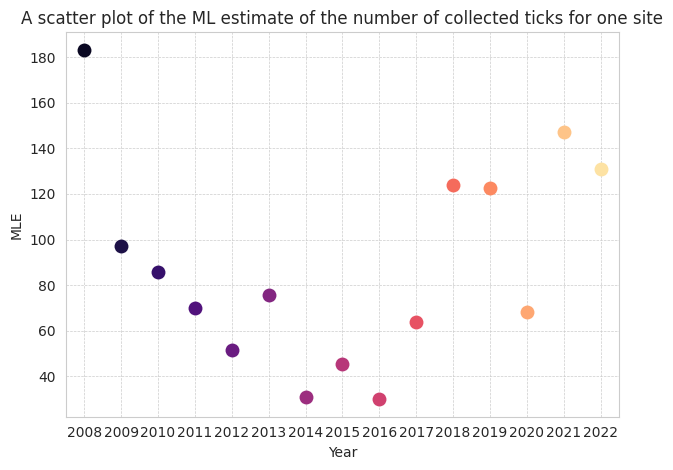

In [11]:
sns.set_style("whitegrid")

sns.stripplot(
    data=dat,
    x='Year',
    y='MLE',
    hue='Year',
    palette='magma',
    size=10,
    legend=False
)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.title("A scatter plot of the ML estimate of the number of collected ticks for one site")
plt.xlabel("Year")
plt.ylabel("MLE")
plt.tight_layout()

plt.show()

The table and the plot above show a changing trend in the number of captures ticks. While their estimated number for one area between 2008 and 2016 was decreasing, after 2016 the opposite is predominantly increasing.

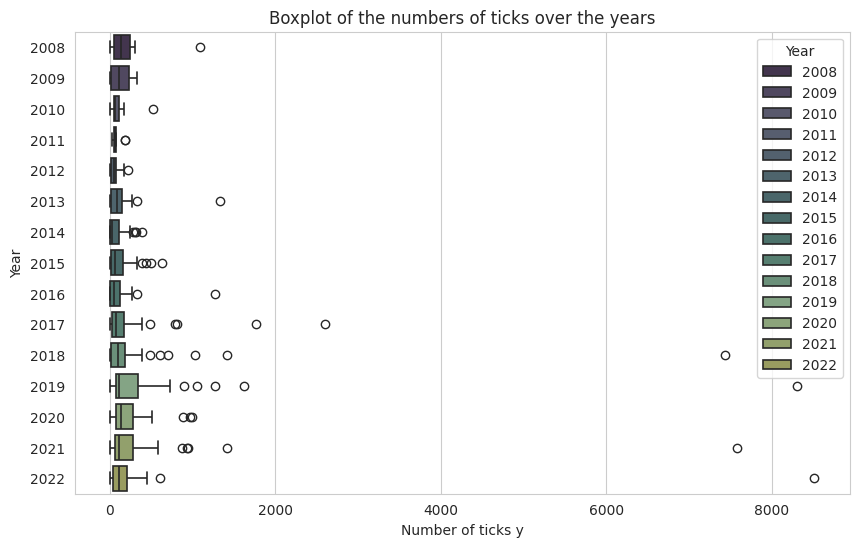

In [12]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=data,
    y='Year',
    x='y',
    hue='Year',
    palette='viridis',
    showfliers=True,
    linewidth=1.2,
    saturation=0.3
)

plt.title("Boxplot of the numbers of ticks over the years")
plt.xlabel("Number of ticks y")
plt.ylabel("Year")

plt.show()

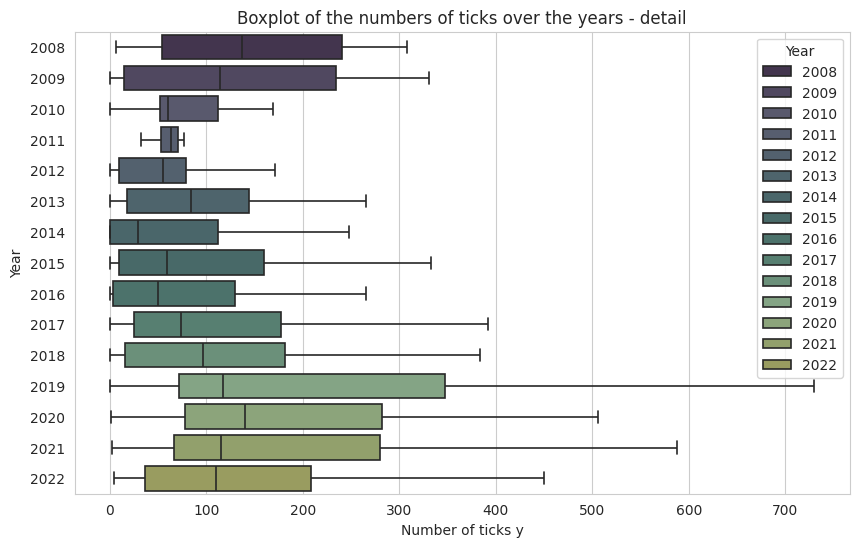

In [13]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=data,
    y='Year',
    x='y',
    hue='Year',
    palette='viridis',
    showfliers=False,
    linewidth=1.2,
    saturation=0.3
)

plt.title("Boxplot of the numbers of ticks over the years - detail")
plt.xlabel("Number of ticks y")
plt.ylabel("Year")

plt.show()

From the plot below we can see that the number of visited sites was not consistent over the period. More recent records predominantly contain data with a larger range of selection.

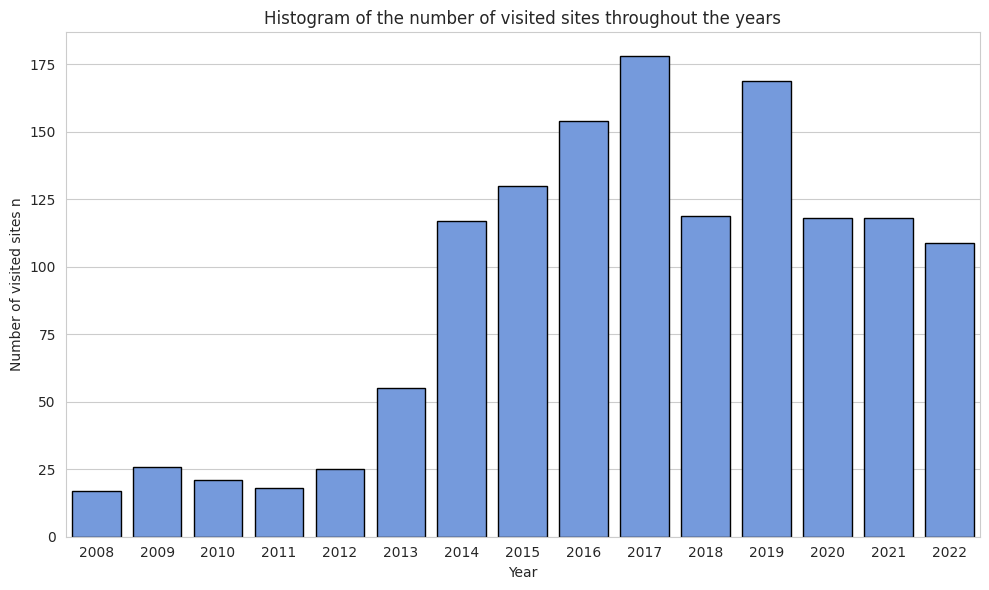

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=dat,
    x='Year',
    y='n',
    color='cornflowerblue',
    edgecolor='black'
)

plt.title("Histogram of the number of visited sites throughout the years")
plt.xlabel("Year")
plt.ylabel("Number of visited sites n")

plt.tight_layout()

plt.show()

Now, let's focus on the features contatining data about the testing for inidividual diseases.

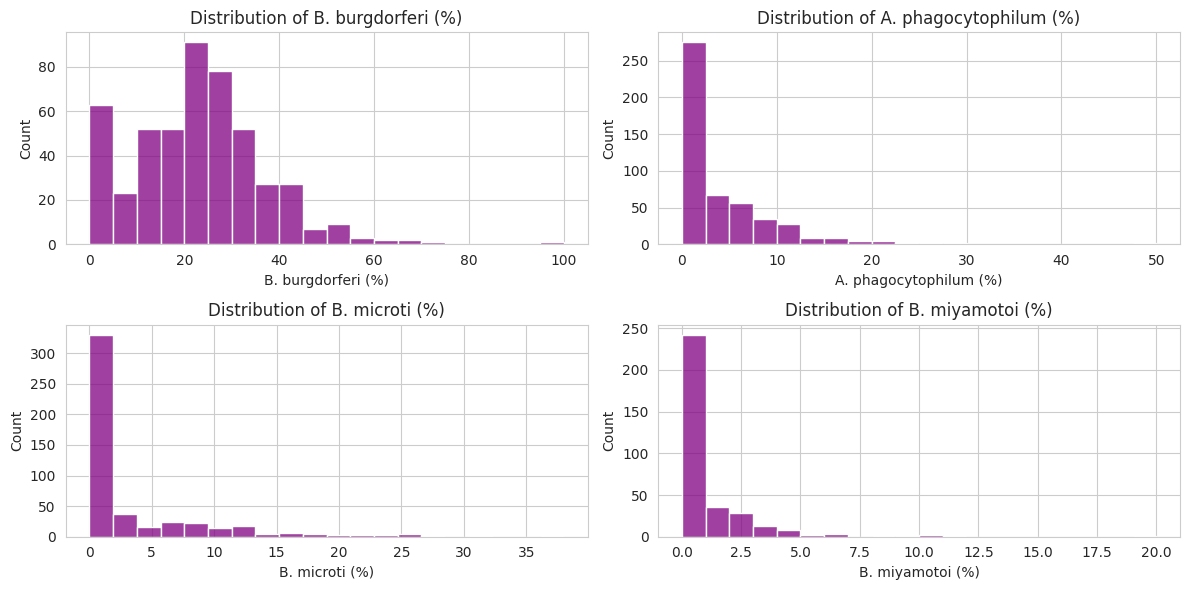

In [15]:
plt.figure(figsize=(12, 6))
for i, disease in enumerate(['B. burgdorferi (%)', 'A. phagocytophilum (%)', 'B. microti (%)', 'B. miyamotoi (%)'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[disease], color='purple', bins=20)
    plt.title(f"Distribution of {disease}")
plt.tight_layout()
plt.show()

We can also focus on the prevalence of diseases over time. From the plots below the trend seems to be increasing in general.

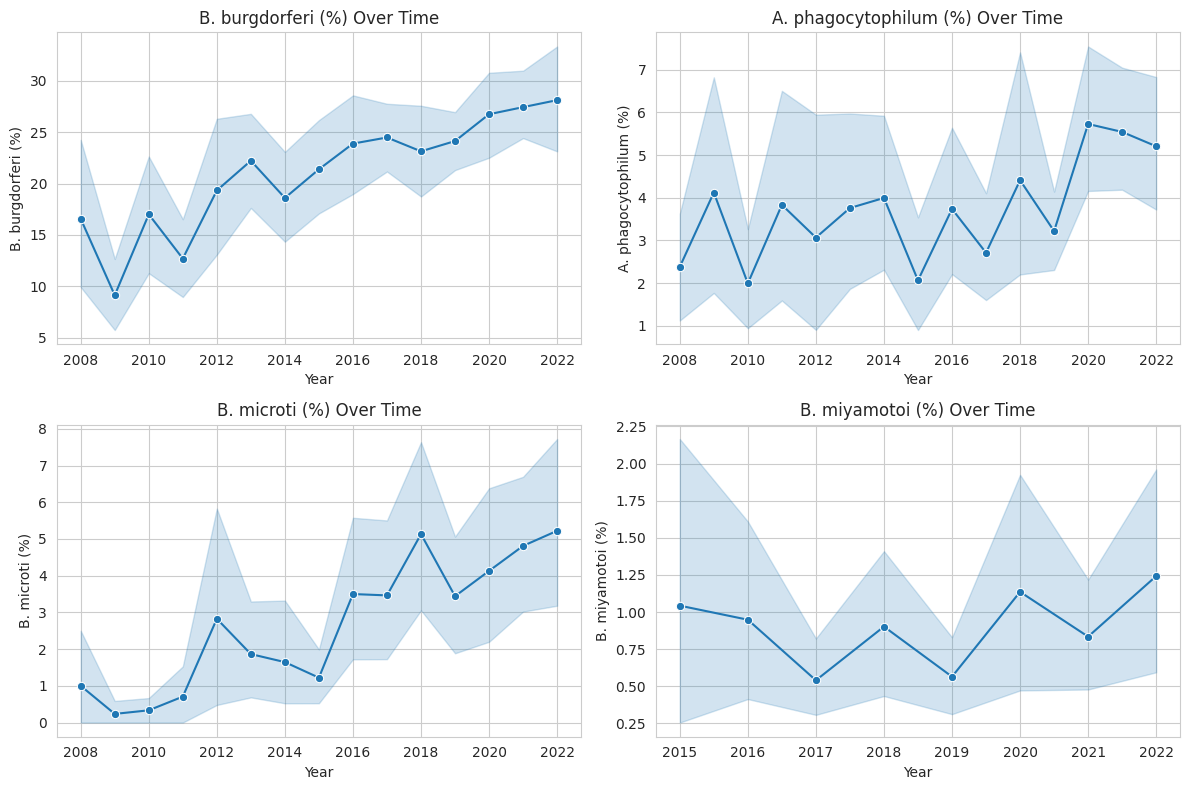

In [16]:
plt.figure(figsize=(12, 8))
for i, disease in enumerate(['B. burgdorferi (%)', 'A. phagocytophilum (%)', 'B. microti (%)', 'B. miyamotoi (%)'], 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=data, x='Year', y=disease, marker='o')
    plt.title(f"{disease} Over Time")
plt.tight_layout()
plt.show()

### Data Preprocessing

Remove the "County" suffix from the key "name".

In [17]:
for i in range(len(counties_json["features"])):  
    counties_json["features"][i]['properties']['name'] = counties_json["features"][i]['properties']['name'].replace(" County", "")

In [18]:
counties = []

for feature in counties_json["features"]:
      counties.append(feature["properties"]["name"])

counties=[*set(counties)]
counties.sort()

We'll create a Cartesian product of the 'County' and 'Year' column.

In [19]:
county_df = pd.DataFrame(counties, columns =['County'])
year_df = pd.DataFrame(list(range(2008, 2023)), columns =['Year'])
data_df = county_df.merge(year_df, how='cross')

In [20]:
data_df = data_df.merge(data[['County', 'Year', 'y', 'n', 't', 'B. burgdorferi (%)', 'A. phagocytophilum (%)', 'B. microti (%)', 'B. miyamotoi (%)']],
                        on=['County', 'Year'], 
                        how='left')

data_df['MLE'] = (data_df['y'] / data_df['n']).round(3)
data_df['MLE'] = data_df['MLE'].fillna(0)

   
for attr in ['y', 'n', 't', 'B. burgdorferi (%)', 'A. phagocytophilum (%)', 'B. microti (%)', 'B. miyamotoi (%)']:
    data_df[attr] = data_df[attr].fillna(0)

In [21]:
data_df

,County,Year,y,n,t,B. burgdorferi (%),A. phagocytophilum (%),B. microti (%),B. miyamotoi (%),MLE
0,Albany,2008,149.0,1.0,50.0,40.0,0.0,0.0,0.0,149.000
1,Albany,2009,252.0,1.0,50.0,20.0,2.0,0.0,0.0,252.000
2,Albany,2010,153.0,1.0,47.0,36.2,6.4,0.0,0.0,153.000
3,Albany,2011,188.0,1.0,50.0,18.0,12.0,2.0,0.0,188.000
4,Albany,2012,220.0,3.0,139.0,28.1,12.2,7.9,0.0,73.333
...,...,...,...,...,...,...,...,...,...,...
925,Yates,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
926,Yates,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
927,Yates,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
928,Yates,2021,11.0,1.0,11.0,27.3,9.1,0.0,0.0,11.000


Summary statistics across years:

In [22]:
stats_total = data_df.groupby(['County']).sum()
stats_total.drop(['Year'],axis=1, inplace=True) 
stats_total = stats_total.reset_index()

### Dash

In [28]:
from dash import Dash, html, dcc, Input, Output, dash_table

app = Dash(__name__)

#*******APP LAYOUT**************

app.layout = html.Div(
    style={'backgroundColor':'#323130',
        'height': '100%',
        'color': 'white',
        'margin': 0,
        'padding': '15px' 
    }, 
    
    children=[
        #****************************HEADER*************************************
        html.H1(children='Tick Surveillance'),

        dcc.Markdown('### Monitoring of Black-Legged Tick Nymphs in the New York State (2008-2022)'),
    
        html.Hr(),
    
        #****************************Map*************************************   
        
        html.Div(
            dcc.Graph(id='map'), 
            style={'width': '90%', 'margin': '0 auto', 'display': 'block'}
        ),

        #****************************Slider*************************************   
        html.Div([
            'Years',
            dcc.Slider(2008, 2022, step = 1, value=2022, id='slider',
                    marks={i: f"{i}" for i in range(2008,2023,1)},
                    tooltip={'placement': 'bottom', 'always_visible': True})
            ], 
            style={'width': '90%', 'margin': '0 auto', 'display': 'block'} ),
        
        #****************************Controls*************************************
        dcc.Markdown('**Disease**'),
        html.Div(children=[
            dcc.RadioItems(['B. burgdorferi', 'A. phagocytophilum', 'B. microti', 'B. miyamotoi'],
                           'B. burgdorferi',
                           id='disease',
                           inline=True)],
            style={'width': '50%', 'display': 'flex'}
        ),

        #****************************Barplot*************************************   
        html.Div(
            [dcc.Graph(id='barplot')], 
            style={'width': '50%', 'display': 'inline-block'},), 
        
        #****************************Timeline*************************************   
        html.Div(
            [dcc.Graph(id='timeline')], 
            style={'width': '50%', 'display': 'inline-block'},), 

        #****************************Footer*************************************   
        html.Footer(
            [
                "Data provided by ",
                html.A(
                    "New York State Department of Health",
                    href="https://health.data.ny.gov/Health/Deer-Tick-Surveillance-Nymphs-May-to-Sept-excludin/kibp-u2ip/data",
                    target="_blank",  # Opens the link in a new tab
                    style={'color': '#FFCC00', 'textDecoration': 'none'}  # Styling for the link
                ),
                "."
            ],
            style={'textAlign': 'center', 'marginTop': '20px', 'color': 'gray', 'fontSize': '15px'}
        )
    ]
 )


#**************FUNCTIONS*****************************

def get_map(year):
    stats_map = data_df[data_df["Year"] == year]
    if not stats_map.empty:
        fig = px.choropleth(stats_map, 
                            geojson=counties_json,
                            featureidkey='properties.name',  # Property in geojson
                            locations='County',  # Column in dataframe matching featureidkey
                            color='MLE',  # Dataframe
                            color_continuous_scale='Purpor',    
                            projection='equirectangular',  # Map projection
                            title='Map',
                            labels={
                                'y': 'Total Ticks Collected',
                                'n': 'Total Sites Visited',
                                'MLE': 'Max Likelihood Estimate'                            
                            },
                            hover_data=['County', 'MLE', 'n', 'y']  # Additional columns for hover
                            )
        fig.update_geos(visible=False)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.update_layout(geo_bgcolor="#323130", geo_showlakes=False, geo_fitbounds="locations",
                          geo_resolution=110, geo_landcolor="#e5f5df", geo_showcountries=True,
                          paper_bgcolor= "#323130", font_color="white",)    
        return fig


def get_county_graph(county):
      timeline = data_df[data_df['County'] == county]
      bars = px.bar(timeline,
                    x="Year",
                    y='MLE',
                    title="County: " + county,
                    )
      bars.update_layout(plot_bgcolor= "#323130", paper_bgcolor= "#323130", font_color="white", xaxis=dict(dtick=1))
      return bars

def get_county_graph2(disease, county):
    timeline = data_df[data_df['County'] == county]
    bars = px.bar(
        data_df[data_df['County'] == county], 
        x="Year", 
        y=disease + ' (%)', 
        title="County: " + county,
        labels={
            't': 'Total Ticks Tested',                       
        },
        hover_data=['Year', 't']
    )
    
    bars.update_layout(
        plot_bgcolor="#323130", 
        paper_bgcolor="#323130", 
        font_color="white",  
        yaxis=dict(
            range=[0, 100]
        ),
        xaxis=dict(dtick=1)
    )
    return bars

#*************CALLBACKS*****************************************

#slider->map
@app.callback(
    Output('map', 'figure'),
    Input('slider', 'value')
)
def update_map(year):
    fig = get_map(year)
    return fig

#map->bars
@app.callback(
    Output('timeline', 'figure'),
    Input('map', 'clickData')
)
def update_timeline(clickData):
    county = "Suffolk"
    if clickData is not None:
        county= clickData['points'][0]["location"]
    bars = get_county_graph(county)
    return bars

#timeline->slider
@app.callback(
    Output("slider", "value"),
    Input('timeline', 'clickData')
)
def update_year(clickData):
    year = 2022
    if clickData is not None:
        year = clickData['points'][0]["x"]
    return year

#radio,map->barplot
@app.callback(
    Output('barplot', 'figure'),
    Input('disease', 'value'),
    Input('map', 'clickData')
)
def update_barplot(disease, clickData):
    county = "Suffolk"
    if clickData is not None:
        county= clickData['points'][0]["location"]
    bars = get_county_graph2(disease, county)
    return bars

#data dump
@app.callback(
    Output('click-data', 'children'),
    Input('map', 'clickData')
)
def update_data(clickData):
    if clickData is not None:
        country= clickData['points'][0]["location"]
        return json.dumps(clickData, indent=2)

#********RUNNING THE APP*************************************************
if __name__ == '__main__':
    app.run_server(port=8090, jupyter_mode="external", debug=False) # inline/tab/external

Dash app running on http://127.0.0.1:8090/
